In [1]:
#The main Jupyter notebook for running our simulation. For now we can also use this notebook to test out code segments

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import CSJModel as csj

In [2]:
#Model Parameters
length_of_growing_season = 150
n_seasons_per_trial = 10
n_trials = 10000
n_plots = 4
plot_capacity = 1000
initial_soil_sat = 0.5
base_soil_sat_loss_rate = 0.05
biomass_water_demand_rate = 0.001
end_of_season_die_off = 0.9
temp = 20
rel_hum = .7

In [3]:
#This is the class/template we can use to create different species of plants. Each Plant object holds the variables/parameters
#that are related to how the species behaves

class Plant:
    
    def __init__(self, n, rate, k, alpha, mass):
        self.name = str(n)
        self.base_growth_rate = rate
        self.ideal_soil_sat = k
        self.ideal_sat_alpha = alpha
        self.biomass = mass
    
    def growth_rate(self, soil_sat):
        return (-1 * self.ideal_sat_alpha * (soil_sat - self.ideal_soil_sat) ** 2 + 1) * self.base_growth_rate

#This line creates a new plant species and saves it in the test variable. This species has a base growth rate of 1%/day, likes 50%
#soil saturation, and has saturation tolerance parameter of 10, and is starting with 10 biomass units
#In order to get the plant's actual growth rate, we call the .growth_rate() method and pass in the current level of soil saturation

test = Plant('my_plant', 0.01, 0.5, 10, 10)

In [4]:
#This class implements a "Plot" container that represents an area/habitat for various plant species.
#The class has a list that [should] contain different species of plant, and keeps track the current
#soil saturation, its carrying capacity, and the soil's base saturation rate. There is also a method that returns
#the total biomass of all plants in the plot, a method to cause the plot to dry out a little, and a method
#to re-hydrate the plot up to a given saturation level (capped at 1.0)

class Plot:
    
    def __init__(self, plant_list, cap, sat, h2o_base_rate):
        self.species_list = plant_list
        self.capacity = cap
        self.soil_saturation = sat
        self.base_saturation_rate = h2o_base_rate
    
    def dry(self):
        self.soil_saturation -= self.base_saturation_rate * self.soil_saturation
    
    def wet(self, sat):
        self.soil_saturation = min(self.soil_saturation + sat, 1.0)
        
    def total_biomass(self):
        total = 0
        for plant in self.species_list:
            total += plant.biomass
        return total



In [5]:
#Set up a function for running a single trial that returns summary results from the trial.

def run_trial(plot):
    daily_list = []
    for time in range(length_of_growing_season):
        datapoint = {'time': time}
        for plant in test_plot.species_list:
            plant.biomass += plant.growth_rate(test_plot.soil_saturation) * plant.biomass * (1 - (plant.biomass/test_plot.capacity))
            datapoint[plant.name + '_biomass'] = plant.biomass
        if random.randint(0, 100) > 94:
            test_plot.wet(0.8)
        else:
            test_plot.dry()
        datapoint['soil_sat'] = test_plot.soil_saturation
        daily_list.append(datapoint)
    df = pd.DataFrame.from_records(daily_list, index='time')
    trial_dict = {}
    for key in df.describe().to_dict().keys():
        trial_dict[key + '_mean'] = df.describe().to_dict()[key]['mean']
        trial_dict[key + '_std'] = df.describe().to_dict()[key]['std']
        trial_dict[key + '_min'] = df.describe().to_dict()[key]['min']
        trial_dict[key + '_med'] = df.describe().to_dict()[key]['50%']
        trial_dict[key + '_max'] = df.describe().to_dict()[key]['max']
    return trial_dict
        

In [7]:
#Outer Monte Carlo-Style loop
trial_list = []
for trial in range(n_trials):
    test_plot = Plot([Plant('my_plant', 0.01, 0.5, 10, 10)], plot_capacity, initial_soil_sat, base_soil_sat_loss_rate)
    trial_list.append(run_trial(test_plot))
trial_df = pd.DataFrame.from_records(trial_list)
trial_df.describe()

,my_plant_biomass_mean,my_plant_biomass_std,my_plant_biomass_min,my_plant_biomass_med,my_plant_biomass_max,soil_sat_mean,soil_sat_std,soil_sat_min,soil_sat_med,soil_sat_max
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.925609,1.354332,9.663451,11.838647,14.506204,0.547923,0.261014,0.117469,0.536828,0.999433
std,1.175356,0.494386,0.879258,1.230141,1.884105,0.099081,0.030446,0.074776,0.130517,0.010012
min,6.862925,0.308558,2.208061,6.639534,10.099000,0.063304,0.107222,0.000228,0.010405,0.475000
25%,11.244381,0.966525,9.620065,11.116242,13.089897,0.486831,0.241065,0.057991,0.457271,1.000000
50%,12.054183,1.311419,10.076063,11.931771,14.479736,0.558125,0.261125,0.104674,0.554580,1.000000
75%,12.748350,1.685839,10.099000,12.683887,15.832249,0.618926,0.280736,0.166083,0.630249,1.000000
max,14.618333,3.145257,10.099000,14.699841,20.623379,0.796206,0.392224,0.463291,0.814506,1.000000


<Axes: >

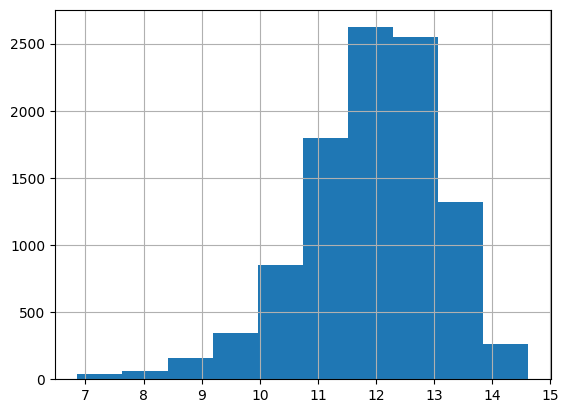

In [8]:
trial_df['my_plant_biomass_mean'].hist()

<Axes: xlabel='time'>

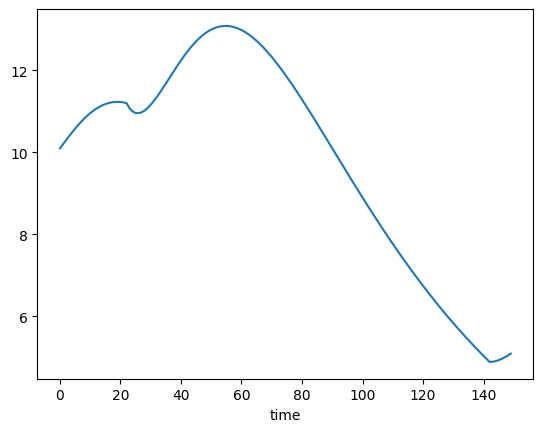

In [10]:
df['my_plant_biomass'].plot()

<Axes: xlabel='time'>

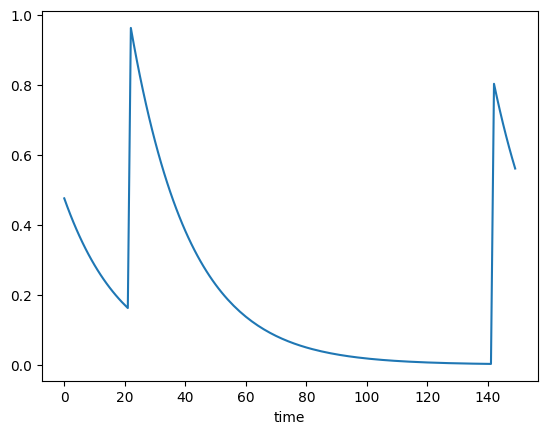

In [11]:
df['soil_sat'].plot()